In [16]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# 데이터 로드 및 전처리
stock = pd.read_csv("/Users/yeomsangyoon/Visual Studio/0_tensor/source/stock.csv")
stock.columns = ['Date', 'Code', 'Name', 'Volume', 'Open', 'High', 'Low', 'Close']
stock_AJ = stock[stock['Code'] == 'A060310']
stock_AJ = stock_AJ[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# MinMaxScaler 함수 정의
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# 데이터 정규화
dfx = stock_AJ[['Open', 'High', 'Low', 'Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]
dfx = dfx[['Open', 'High', 'Low', 'Volume']]

X = dfx.values.tolist()
y = dfy.values.tolist()

# 슬라이딩 윈도우 데이터 분할
window_size = 10

data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i: i + window_size]
    _y = y[i + window_size]
    data_X.append(_X)
    data_y.append(_y)

train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[:train_size])
train_y = np.array(data_y[:train_size])

test_X = np.array(data_X[train_size:])
test_y = np.array(data_y[train_size:])

# 모델 정의 및 학습
model = Sequential()
model.add(Input(shape=(window_size, 4)))  # Input 레이어 추가
model.add(LSTM(units=100, activation='relu', return_sequences=True))  # LSTM 유닛 수 증가
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(units=100, activation='relu'))  # LSTM 유닛 수 증가
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,901 (480.08 KB)

 Trainable params: 122,701 (479.30 KB)

 Non-trainable params: 200 (800.00 B)

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.2)

# 예측 및 평가
pred_y = model.predict(test_X)
model.evaluate(test_X, test_y)

# 추가 평가 지표
mae = tf.keras.metrics.mean_absolute_error(test_y, pred_y)
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(tf.cast(test_y, tf.float32), tf.cast(pred_y, tf.float32))
rmse_result = rmse.result().numpy()

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1559 - val_loss: 0.0445
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0366 - val_loss: 0.0403
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0174 - val_loss: 0.0431
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0153 - val_loss: 0.0398
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0393
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088 - val_loss: 0.0374
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0099 - val_loss: 0.0395
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106 - val_loss: 0.0360
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0097 - val_loss: 0.0373
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0094 - val_loss: 0.0347
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0096 - val_loss: 0.0345
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0097 - val_lo

In [18]:
print(f'MSE: {tf.reduce_mean(tf.square(test_y - pred_y)).numpy()}')
print('\n'+f'MAE: {mae.numpy()}')
print('\n'+f'RMSE: {rmse_result}')

MSE: 0.02735227955118134

MAE: [0.12199575 0.11623205 0.10621795 0.098666   0.11812733 0.10275993
 0.08184354 0.06926504 0.04672028 0.02678603 0.03027561 0.03007963
 0.01682323 0.00398085 0.03426722 0.00510234 0.01865223 0.05330318
 0.05213709 0.04495402 0.06402358 0.07450409 0.07662359 0.08196238
 0.07438312 0.07524855 0.0862844  0.12678838 0.12927873 0.15175219
 0.11727627 0.1020053  0.11053737 0.0978574  0.10664907 0.1280551
 0.15307255 0.18344161 0.19857663 0.18743417 0.20370215 0.2259958
 0.19493574 0.2062742  0.23369393 0.26302755 0.266806   0.22143099
 0.22710975 0.19814989 0.1774598  0.17225341 0.17467824 0.17546982
 0.17596123 0.17632934 0.19761005 0.20388722 0.18847373 0.1826511
 0.16345799 0.16739118 0.16369909 0.16563806 0.16763428 0.15444274
 0.1488435  0.1392643  0.14950404 0.13778041 0.13002586 0.13997395
 0.17352296 0.19012363 0.16823888 0.18294206 0.1803982  0.16849385
 0.16844548 0.13961521 0.13317494 0.14365213 0.17045972 0.18494037
 0.18075283 0.17999204 0.16594507 

In [19]:
from sklearn.metrics import mean_squared_error

ry_preds = model.predict(test_X)
print('평균제곱근오차', mean_squared_error(ry_preds, test_y))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
평균제곱근오차 0.02735227955118134


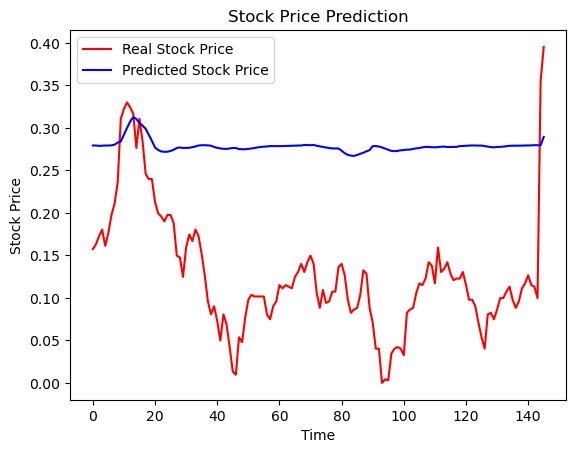

In [20]:
# 결과 시각화
plt.figure()
plt.plot(test_y, color='red', label='Real Stock Price')
plt.plot(pred_y, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [6]:
#----------------------------------------------------------------------------------------------------------------------------------

In [7]:
#----------------------------------------------------------------------------------------------------------------------------------

In [8]:
#----------------------------------------------------------------------------------------------------------------------------------

In [9]:
#----------------------------------------------------------------------------------------------------------------------------------

In [10]:
# RNN 사용 예제

In [11]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 로드 및 전처리
stock = pd.read_csv("/Users/yeomsangyoon/Visual Studio/0_tensor/source/stock.csv")
stock.columns = ['Date', 'Code', 'Name', 'Volume', 'Open', 'High', 'Low', 'Close']
stock_AJ = stock[stock['Code'] == 'A060310']
stock_AJ = stock_AJ[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# MinMaxScaler 함수 정의
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# 데이터 정규화
dfx = stock_AJ[['Open', 'High', 'Low', 'Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]
dfx = dfx[['Open', 'High', 'Low', 'Volume']]

X = dfx.values.tolist()
y = dfy.values.tolist()

# 슬라이딩 윈도우 데이터 분할
window_size = 10

data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i: i + window_size]
    _y = y[i + window_size]
    data_X.append(_X)
    data_y.append(_y)

train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[:train_size], dtype=np.float32)
train_y = np.array(data_y[:train_size], dtype=np.float32)

test_X = np.array(data_X[train_size:], dtype=np.float32)
test_y = np.array(data_y[train_size:], dtype=np.float32)

# 모델 정의 및 학습
model = Sequential()
model.add(Input(shape=(window_size, 4)))  # Input 레이어 추가
model.add(SimpleRNN(units=50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(SimpleRNN(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

# Early Stopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# 예측 및 평가
pred_y = model.predict(test_X)
model.evaluate(test_X, test_y)

# 추가 평가 지표
mae = tf.keras.metrics.mean_absolute_error(test_y, pred_y)
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(test_y, pred_y)
rmse_result = rmse.result().numpy()

print(f"MSE: {tf.reduce_mean(tf.square(test_y - pred_y)).numpy()}")
print(f"MAE: {mae.numpy()}")
print(f"RMSE: {rmse_result}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10, 50)         │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,051 (31.45 KB)

 Trainable params: 7,951 (31.06 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5941 - val_loss: 0.0553
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3310 - val_loss: 0.0603
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3489 - val_loss: 0.0624
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1838 - val_loss: 0.0541
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1371 - val_loss: 0.0524
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1098 - val_loss: 0.0486
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0850 - val_loss: 0.0414
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0830 - val_loss: 0.0406
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0764 - val_loss: 0.0394
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0698 - val_loss: 0.0342
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0565 - val_loss: 0.0346
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0625 - val_loss: 0.0334


In [12]:
from sklearn.metrics import mean_squared_error

ry_preds = model.predict(test_X)
print('평균제곱근오차', mean_squared_error(ry_preds, test_y))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
평균제곱근오차 0.0027556976


In [15]:
# 정확도가 0.00275으로 굉장히 좋게 나오는 것을 볼 수 있다.

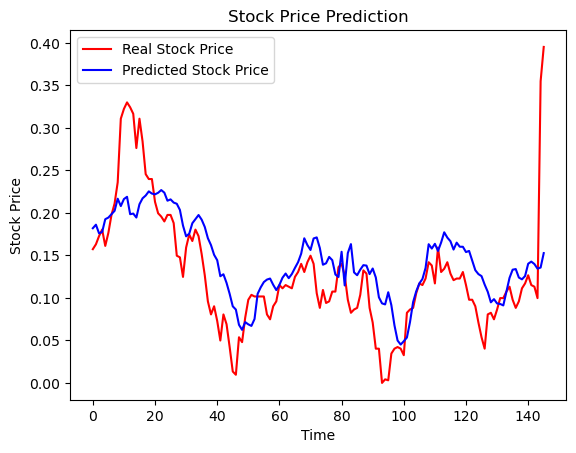

In [14]:
# 결과 시각화
plt.figure()
plt.plot(test_y, color='red', label='Real Stock Price')
plt.plot(pred_y, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()